In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore") 
import scipy.stats as st
from patsy import dmatrix, dmatrices

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 16.2 Data generation

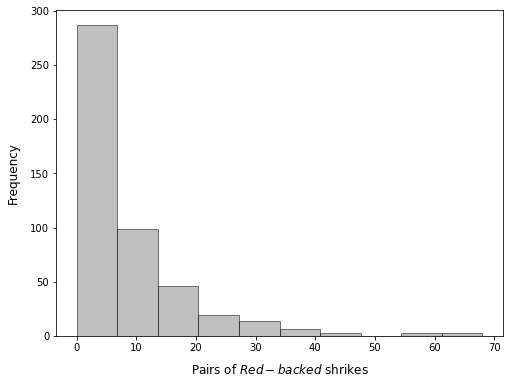

In [2]:
np.random.seed(123456)
n_groups = 16
n_years = 30
n = n_groups * n_years
pop = np.repeat(range(1, n_groups + 1), n_years)
original_year = np.tile(range(1, n_years + 1), n_groups)
year = (original_year - 1) / 29
data_ds = pd.DataFrame({'pop': pd.Series(pop, dtype = 'category'), 'year': year})
Xmat = dmatrix("~ pop * year - 1 - year", data_ds, return_type = 'dataframe')

intercept_mean = 3                       # Choose values for the hyperparams
intercept_sd = 1
slope_mean = -2
slope_sd = 0.6
intercept_effects = st.norm.rvs(intercept_mean, intercept_sd, size = n_groups)
slope_effects = st.norm.rvs(slope_mean, slope_sd, size = n_groups)
all_effects = np.concatenate((intercept_effects, slope_effects))

lin_pred = Xmat.to_numpy() @ all_effects
λ = np.exp(lin_pred)
C = np.random.poisson(λ)

data = pd.DataFrame({'C': C, 'pop': pop, 'or_year': original_year})

plt.figure(figsize = (8, 6))
plt.hist(C, color= 'gray', edgecolor='black', alpha = 0.5)
plt.xlabel('Pairs of $Red-backed$ shrikes', fontsize = 12, labelpad = 10)
plt.ylabel('Frequency', fontsize = 12, labelpad = 10);

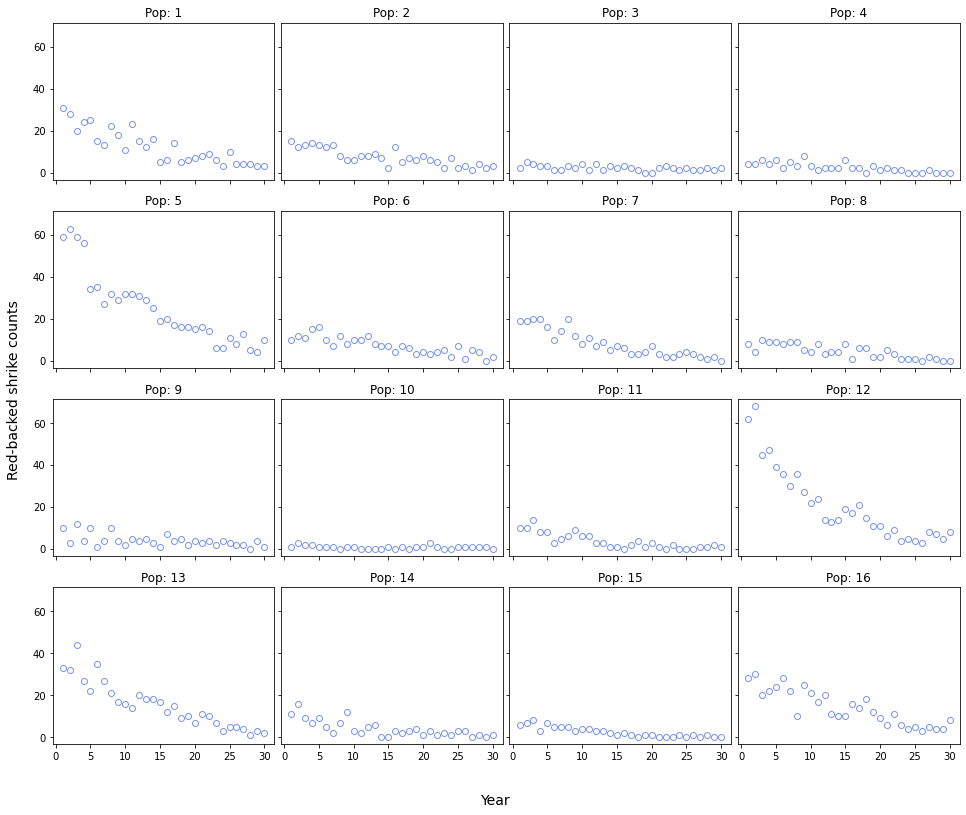

In [3]:
fig, axes = plt.subplots(4, 4, figsize=(14, 12), sharey=True, sharex=True)
fig.subplots_adjust(left=0.075, right=0.975, bottom=0.09, top=0.925, wspace=0.03)

axes_flat = axes.ravel()

for i, pop_ in enumerate(range(1, n_groups + 1)):
    ax = axes_flat[i]
    idx_ = data.index[data["pop"] == pop_].tolist()
    C_ = data.loc[idx_, "C"].values
    year_ = data.loc[idx_, "or_year"].values

    # Plot observed data points
    ax.scatter(year_, C_, color="white", ec="royalblue", alpha=0.7)

    # Add a title
    ax.set_title(f"Pop: {pop_}", fontsize=12)

fig.text(0.5, 0.02, "Year", fontsize=14)
fig.text(0.03, 0.5, "Red-backed shrike counts", rotation=90, fontsize=14, va="center");

### 16.3 Random-coefficients model

#### 16.3.2 Analysis using PyMC3

In [4]:
idx = pd.factorize(pop)[0] 
groups = len(np.unique(idx))

In [5]:
with pm.Model() as model_16_3_2:
    
    mu_int = pm.Normal('mu_int', 0, tau = 0.001)
    sigma_int = pm.Uniform('sigma_int', 0, 10)
    mu_beta = pm.Normal('mu_beta', 0, tau = 0.001)
    sigma_beta = pm.Uniform('sigma_beta', 0, 10)
    
    alpha = pm.Normal('alpha', mu_int, sigma = sigma_int, shape = groups)
    beta = pm.Normal('beta', mu_beta, sigma_beta, shape = groups)
    λ = pm.Deterministic('λ', pm.math.exp(alpha[idx] + beta[idx] * year))
    C_pred = pm.Poisson('C_pred', λ, observed = C)
    
    trace_16_3_2 = pm.sample(target_accept = 0.97, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_beta, mu_beta, sigma_int, mu_int]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 41 seconds.


In [6]:
az.summary(trace_16_3_2, var_names = ['mu_int', 'sigma_int', 'mu_beta', 'sigma_beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_int,2.642,0.274,2.100,3.138,0.005,0.004,2625.0,1215.0,1.0
sigma_int,1.056,0.227,0.687,1.463,0.005,0.004,2634.0,1057.0,1.0
mu_beta,-2.184,0.161,-2.486,-1.890,0.004,0.003,1714.0,1731.0,1.0
sigma_beta,0.570,0.163,0.299,0.881,0.005,0.003,1169.0,1475.0,1.0
